# Inferential statistics
IN this notebook we merge crime and socio economic data and then perform a range of statistical analyses to understand which characteristics have an effect on the levels of serious violent crime in an area.

The first step is to identify which features are most highly correlated with the level of serious violent crime.
- For this we will use the spearman correlation, because this is a median rather than mean based statistical measure, which is necessary because, as we'd established previously, a number of our features have skewed distributions and so a robust measure is needed to compare like with like across all our features.
- The output from this step will be a dataset containing 4835 LSOAs, for which we will have: 
    - The characteristics (or features) for each of those areas that are most highly correlated with serious violent crime
    - the serious violent crime rate per 1000 inhabitants for each area.
    
We then want to look at areas with high, medium and low serious violent crime rates in order to understand whether the characteristics in those areas are measurably different. This difference is called an effect size, and we will use the Cohen's D statistical measure in order to calculate it.
    - It should be noted that Cohen's D is a mean based measure and so we need to ensure our distributions are nearly normal in order for us to be able to rely on its results.
    
In our crime context analysis, we found that the top 250 LSOAs (out of nearly 5,000) experienced almost 19% of the crime in London. This means we can't simply split our data into 3 subsets of around 1700 LSOAs because that will obscure the fact that there are particular areas which have very high crime rates and it is the conditions in these areas that we are particularly interested in. We therefore propose creating subsets of data containing 250 and 500 LSOAs so that we capture the nuances about an area. For example, if the slice size is 250, we will create one slice containing the 250 LSOAs with the highest crime, another with 250 LSOAs experiencing mid level crime and the final slice containing 250 LSOAs with the least crime. For these slices (250 and 500), we will then produce the following:
- distribution and outlier analysis for each slice
- cohens D comparing size of effect in each feature between populations of high vs mid level crime, high vs low level crime and mid vs low level crime
- we will also derive the confidence interval for this effect size

<b> It should be noted we retrospectively repeated our analysis for a slice of size 1000 because a random forest classifier training on this sized cohort produced the best prediction results and so we wanted to see how it performed in the inference analysis </b>

Having performed this analysis we will then understand whether there is a material difference in the characteristics of areas experiencing high, mid and low levels of serious violent crime.

- also need to remember we haven't done any analysis of exclusions, looked after children and mental health yet


In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import altair as alt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
import numpy as np

### Load socioeconomic data

In [2]:
london_features = pd.read_csv("./DataSources/Income and Deprivation/socio_economic_features.csv")
print(london_features.shape)
london_features.head()

(4835, 27)


lsoa_code                  lsoa_name   lad_code              lad_name  \
0  E01000001        City of London 001A  E09000001        City of London   
1  E01000002        City of London 001B  E09000001        City of London   
2  E01000003        City of London 001C  E09000001        City of London   
3  E01000005        City of London 001E  E09000001        City of London   
4  E01000006  Barking and Dagenham 016A  E09000002  Barking and Dagenham   

   income_deprivation_score  employment_deprivation_score  \
0                     0.007                         0.010   
1                     0.034                         0.027   
2                     0.086                         0.086   
3                     0.211                         0.136   
4                     0.117                         0.059   

   child_income_deprivation_score  lone_parent_pct  ethnic_white_pct  \
0                           0.006         0.026256          0.845051   
1                           0.037         0.026506          0.887187   
2                           0.052         0.059976          0.783804   
3                           0.209         0.094218          0.513706   
4                           0.155         0.099448          0.327070   

   ethnic_mixed_pct  ...  no_qualifications_pct  degree_educated_pct  \
0          0.036860  ...                  0.019                0.776   
1          0.037604  ...                  0.023                0.792   
2          0.040862  ...                  0.130                0.568   
3          0.059898  ...                  0.244                0.345   
4          0.034058  ...                  0.182                0.329   

   population_density  median_house_price  log_rent_social_pct  \
0            0.140067            0.132214            -3.057608   
1            0.077879            0.157300            -2.847312   
2            0.284826            0.082149            -1.018877   
3            0.075522            0.066430            -0.403467   
4            0.144255            0.034776            -3.411248   

   log_ethnic_other_pct  log_population_density  log_median_house_price  \
0             -3.763250               -1.965633               -2.023336   
1             -5.072392               -2.552593               -1.849602   
2             -4.069398               -1.255877               -2.499220   
3             -3.064000               -2.583326               -2.711609   
4             -3.528124               -1.936171               -3.358826   

   log_ethnic_black_pct  log_ethnic_asian_pct  
0             -4.891715             -2.437580  
1             -5.883322             -2.715740  
2             -3.398230             -2.080929  
3             -2.287471             -1.279514  
4             -2.263997             -0.682052  

[5 rows x 27 columns]

### Load and merge crime data
We remember from our crime analysis that if we bound our distribution to LSOAs where the crime_per_1000 is less than 26.5 (which are the upper and lower fences in the boxplot), we remove the extreme outliers and the remaining distribution is more close to normal. Doing so only removes 252 of 4,829 observations (LSOAs), which is around 4.5% of our overall distribution. This will be our strategy for the inferential statistics

In [3]:
london_crimes = pd.read_csv("./DataSources/Crime and outcomes/violent_crimes.csv")
crimes_subset = london_crimes[(london_crimes.crime_per_1000 < 26.5)].copy()
print(crimes_subset.shape)
crimes_subset.head()

(4506, 9)


lsoa_code               borough  ldn_datastore_total  police_total  \
0  E01000006  Barking and Dagenham                   27          50.0   
2  E01000008  Barking and Dagenham                   23          89.0   
5  E01000011  Barking and Dagenham                   13          49.0   
6  E01000012  Barking and Dagenham                   24          54.0   
7  E01000013  Barking and Dagenham                   49         134.0   

   LSOA Code                  lsoa_name  population  crime_per_1000  \
0  E01000006  Barking and Dagenham 016A        2094       12.893983   
2  E01000008  Barking and Dagenham 015B        1597       14.402004   
5  E01000011  Barking and Dagenham 016C        1726        7.531866   
6  E01000012  Barking and Dagenham 015D        2343       10.243278   
7  E01000013  Barking and Dagenham 013A        1855       26.415094   

   crime_per_1000_proportion  
0                   0.218365  
2                   0.243903  
5                   0.127555  
6                   0.173474  
7                   0.447350

In [4]:
violence_socio_economic = pd.merge(crimes_subset, london_features, left_on='lsoa_code', 
                            right_on='lsoa_code', how = 'inner')

violence_socio_economic.rename(columns = {'lsoa_name_x':'lsoa_name'}, inplace = True)
violence_socio_economic.drop('lsoa_name_y', axis=1, inplace=True)
violence_socio_economic.drop('LSOA Code', axis=1, inplace=True)

print(violence_socio_economic.shape)
violence_socio_economic.head()

(4506, 33)


lsoa_code               borough  ldn_datastore_total  police_total  \
0  E01000006  Barking and Dagenham                   27          50.0   
1  E01000008  Barking and Dagenham                   23          89.0   
2  E01000011  Barking and Dagenham                   13          49.0   
3  E01000012  Barking and Dagenham                   24          54.0   
4  E01000013  Barking and Dagenham                   49         134.0   

                   lsoa_name  population  crime_per_1000  \
0  Barking and Dagenham 016A        2094       12.893983   
1  Barking and Dagenham 015B        1597       14.402004   
2  Barking and Dagenham 016C        1726        7.531866   
3  Barking and Dagenham 015D        2343       10.243278   
4  Barking and Dagenham 013A        1855       26.415094   

   crime_per_1000_proportion   lad_code              lad_name  ...  \
0                   0.218365  E09000002  Barking and Dagenham  ...   
1                   0.243903  E09000002  Barking and Dagenham  ...   
2                   0.127555  E09000002  Barking and Dagenham  ...   
3                   0.173474  E09000002  Barking and Dagenham  ...   
4                   0.447350  E09000002  Barking and Dagenham  ...   

   no_qualifications_pct  degree_educated_pct  population_density  \
0                  0.182                0.329            0.144255   
1                  0.211                0.242            0.100393   
2                  0.180                0.296            0.215516   
3                  0.144                0.331            0.172241   
4                  0.335                0.169            0.099503   

   median_house_price  log_rent_social_pct  log_ethnic_other_pct  \
0            0.034776            -3.411248             -3.528124   
1            0.012705            -0.406466             -3.371840   
2            0.031008            -2.563950             -3.548639   
3            0.023256            -1.509593             -3.765946   
4            0.021318            -0.939048             -5.805135   

   log_population_density  log_median_house_price  log_ethnic_black_pct  \
0               -1.936171               -3.358826             -2.263997   
1               -2.298662               -4.365794             -0.989502   
2               -1.534720               -3.473518             -2.435942   
3               -1.758862               -3.761200             -1.277258   
4               -2.307566               -3.848211             -1.765599   

   log_ethnic_asian_pct  
0             -0.682052  
1             -1.487060  
2             -0.423372  
3             -1.035423  
4             -2.308627  

[5 rows x 33 columns]

In [5]:
import scipy.stats as stats
def PearsonSpearman(feature, outcome, feature_desc):
    corrSpearman, pValSpearman = stats.spearmanr(feature, outcome)
    correlation_result = {'Feature': feature_desc, 'Spearman Correlation': corrSpearman, 'Spearman Pvalue': pValSpearman}
    
    return correlation_result

correlation_results = pd.DataFrame(columns=['Feature', 'Spearman Correlation', 'Spearman Pvalue'])

# <------------------------------ Correlations using original values ---------------------------->

correlation_results = correlation_results.append(PearsonSpearman(violence_socio_economic.crime_per_1000, violence_socio_economic.child_income_deprivation_score, 
                                                                 'child income deprivation'), ignore_index=True)
correlation_results = correlation_results.append(PearsonSpearman(violence_socio_economic.crime_per_1000, violence_socio_economic.income_deprivation_score, 
                                                                 'income deprivation'), ignore_index=True)
correlation_results = correlation_results.append(PearsonSpearman(violence_socio_economic.crime_per_1000, violence_socio_economic.employment_deprivation_score, 
                                                                 'employment deprivation'), ignore_index=True)

correlation_results = correlation_results.append(PearsonSpearman(violence_socio_economic.crime_per_1000, 
                                                                 violence_socio_economic.lone_parent_pct, 
                                                                 'lone parent'), ignore_index=True)
correlation_results = correlation_results.append(PearsonSpearman(violence_socio_economic.crime_per_1000, 
                                                                 violence_socio_economic.ethnic_white_pct, 
                                                                 'ethnic white'), ignore_index=True)
correlation_results = correlation_results.append(PearsonSpearman(violence_socio_economic.crime_per_1000, 
                                                                 violence_socio_economic.ethnic_mixed_pct, 
                                                                 'ethnic mixed'), ignore_index=True)
correlation_results = correlation_results.append(PearsonSpearman(violence_socio_economic.crime_per_1000, 
                                                                 violence_socio_economic.homeowner_outright_pct, 
                                                                 'home owner'), ignore_index=True)
correlation_results = correlation_results.append(PearsonSpearman(violence_socio_economic.crime_per_1000, 
                                                                 violence_socio_economic.rent_private_pct, 
                                                                 'private renters'), ignore_index=True)
correlation_results = correlation_results.append(PearsonSpearman(violence_socio_economic.crime_per_1000, 
                                                                 violence_socio_economic.no_qualifications_pct, 
                                                                 'no qualifications'), ignore_index=True)
correlation_results = correlation_results.append(PearsonSpearman(violence_socio_economic.crime_per_1000, 
                                                                 violence_socio_economic.degree_educated_pct, 
                                                                 'degree educated'), ignore_index=True)

# <------------------------------ Correlations using log values ---------------------------->

correlation_results = correlation_results.append(PearsonSpearman(violence_socio_economic.crime_per_1000, 
                                                                 violence_socio_economic.log_rent_social_pct, 
                                                                 'log(social housing)'), ignore_index=True)
correlation_results = correlation_results.append(PearsonSpearman(violence_socio_economic.crime_per_1000, 
                                                                 violence_socio_economic.log_ethnic_asian_pct, 
                                                                 'log(ethnic asian)'), ignore_index=True)
correlation_results = correlation_results.append(PearsonSpearman(violence_socio_economic.crime_per_1000, 
                                                                 violence_socio_economic.log_ethnic_black_pct, 
                                                                 'log(ethnic black)'), ignore_index=True)
correlation_results = correlation_results.append(PearsonSpearman(violence_socio_economic.crime_per_1000, 
                                                                 violence_socio_economic.log_ethnic_other_pct, 
                                                                 'log(ethnic other)'), ignore_index=True)
correlation_results = correlation_results.append(PearsonSpearman(violence_socio_economic.crime_per_1000, 
                                                                 violence_socio_economic.log_population_density, 
                                                                 'log(population_density)'), ignore_index=True)
correlation_results = correlation_results.append(PearsonSpearman(violence_socio_economic.crime_per_1000, 
                                                                 violence_socio_economic.log_median_house_price, 
                                                                 'log(median_house_price)'), ignore_index=True)


sorted_correlations = correlation_results.sort_values(by='Spearman Correlation', ascending=False)

In [6]:
bars_1 = alt.Chart(sorted_correlations, title='Speaman correlations between features and crime/1000').mark_bar(opacity=0.6, color='firebrick').encode(
    x=alt.X('Spearman Correlation:Q', axis=alt.Axis(title='correlation', ticks=False, values=[-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5])),
    y=alt.Y('Feature:N', axis=alt.Axis(title=None, ticks=False), sort='-x')
)

text_1 = alt.Chart(sorted_correlations).mark_text(
    align='center',
    baseline='middle',
    color='black',
    dx=20  # Nudges text to left so it doesn't appear on top of the bar
).encode(
    x=alt.X('Spearman Correlation:Q', axis=alt.Axis(title='correlation', ticks=False, values=[0, 0.1, 0.2, 0.3, 0.4, 0.5])),
    y=alt.Y('Feature:N', axis=alt.Axis(title=None, ticks=False), sort='-x'),
    text=alt.Text('Spearman Correlation:Q', format=',.3r')
)

(bars_1 + text_1).configure_axis(
    grid=False,
    domain=False
).configure_view(
    strokeWidth=0).properties(height=400, width=500)

alt.LayerChart(...)

### Comments
A moderate correlation between two variables has a Spearman correlation above 0.5 and so the following features can be considered to have a moderate correlation:
- income deprivation
- child income deprivation
- employment deprivation
- log(social housing)
- home owner (which is inversely correlated)

The remaining features have low correlation and so we will not consider them further. It should be noted that the features most highly correlated with crime in 2019 use data that was also collected in 2019 whereas the other data was taken from the London Atlas, which was based on 2011 data. This means it is not possible to conclude that these features are far less correlated because we don't know the extent to which their correlations with crime were reduced by virtue of being 8 years out of date. This will be reported in our results.

We will now drill into the moderately correlated variables, focusing specifically on those with the highest correlations, namely income, child income and employment deprivation.

In [27]:
chart_1 = alt.Chart(violence_socio_economic, title='child income deprivation vs crime/1000').mark_point().encode(
    x=alt.X('child_income_deprivation_score:Q', axis=alt.Axis(title='child income deprivation', ticks=False, values=[0.2,0.4])),
    y=alt.Y('crime_per_1000:Q', axis=alt.Axis(title='crime/1000', ticks=False, values=[0,20,40,60])), 
    tooltip=['lsoa_name:N', 'crime_per_1000']
)

line_1 = chart_1.transform_regression('child_income_deprivation_score', 'crime_per_1000').mark_line(color='red')

text_1 = alt.Chart(violence_socio_economic).transform_regression(
    'child_income_deprivation_score', 'crime_per_1000', params=True
).mark_text(align='left').encode(
    x=alt.value(295),  # pixels from left
    y=alt.value(115),  # pixels from top
    text=alt.Text('rSquared:N', format=',.3r')
)

text_1_2 = alt.Chart({'values':[{'x': 0.47, 'y': 30}]}).mark_text(
    text='r^2 ='
).encode(
    x='x:Q', y='y:Q'
)

child_income_chart = (chart_1 + line_1 + text_1 + text_1_2).properties(height=300, width=300)

In [28]:
chart_2 = alt.Chart(violence_socio_economic, title='income deprivation vs crime/1000').mark_point().encode(
    x=alt.X('income_deprivation_score:Q', axis=alt.Axis(title='income deprivation', ticks=False, values=[0.2,0.4])),
    y=alt.Y('crime_per_1000:Q', axis=None), 
    tooltip=['lsoa_name:N', 'crime_per_1000']
)

line_2 = chart_2.transform_regression('income_deprivation_score', 'crime_per_1000').mark_line(color='red')

text_2 = alt.Chart(violence_socio_economic).transform_regression(
    'income_deprivation_score', 'crime_per_1000', params=True
).mark_text(align='left').encode(
    x=alt.value(283),  # pixels from left
    y=alt.value(102),  # pixels from top
    text=alt.Text('rSquared:N', format=',.3r')
)

text_2_2 = alt.Chart({'values':[{'x': 0.40, 'y': 43}]}).mark_text(
    text='r^2 ='
).encode(
    x='x:Q', y='y:Q'
)

income_chart = (chart_2 + line_2 + text_2 + text_2_2).properties(height=300, width=300)

In [29]:
chart_3 = alt.Chart(violence_socio_economic, title='employment deprivation vs crime/1000').mark_point().encode(
    x=alt.X('employment_deprivation_score:Q', axis=alt.Axis(title='employment deprivation', ticks=False, values=[0.1,0.2,0.3])),
    y=alt.Y('crime_per_1000:Q', axis=None), 
    tooltip=['lsoa_name:N', 'crime_per_1000']
)

line_3 = chart_3.transform_regression('employment_deprivation_score', 'crime_per_1000').mark_line(color='red')

text_3 = alt.Chart(violence_socio_economic).transform_regression(
    'employment_deprivation_score', 'crime_per_1000', params=True
).mark_text(align='left').encode(
    x=alt.value(240),  # pixels from left
    y=alt.value(106),  # pixels from top
    text=alt.Text('rSquared:N', format=',.3r')
)

text_3_2 = alt.Chart({'values':[{'x': 0.26, 'y': 42}]}).mark_text(
    text='r^2 ='
).encode(
    x='x:Q', y='y:Q'
)

employment_chart = (chart_3 + line_3 + text_3 + text_3_2).properties(height=300, width=300)

In [10]:
(child_income_chart | income_chart | employment_chart).configure_axis(
    grid=False,
    domain=False
).configure_view(
    strokeWidth=0)

alt.HConcatChart(...)

### Comments
The correlations were observed were significantly lower than those observed in the GLA analysis but we do replicate their broad conclusion that deprivation is a leading correlate with crime, albeit in our case this is just a moderate correlation. 

However, the bottom left quadrants of these scatter plots are most highly populated quadrants and these quadrants represent areas with lower crime and lower deprivation. Meanwhile, the bottom right quadrant is where we see areas with high deprivation and low crime rates and this is more sparsely populated. We will investigate this further using Cohen's D for samples from different places within the population. We will specifically derive the Cohen's D for child income deprivation, income deprivation and employment deprivation for the following populations:
- High Crime vs Low Crime
- High Crime vs Medium 

However we first need to reload our crime data and strip out Westminster LSOAs from the dataset. We need to load this second dataset because the crime data used previously excluded values with crime_1000 below 1.35 or above 62.1

In [11]:
remove_list = ['Westminster 018A', 'Westminster 013E', 'Westminster 018C', 'Westminster 013B']

print(london_crimes.shape)
crimes_subset_new = london_crimes[~london_crimes.lsoa_name.isin(remove_list)].copy()
print(crimes_subset_new.shape)

deprivation = london_features[['lsoa_code', 
                               'lsoa_name', 
                               'lad_code', 
                               'lad_name', 
                               'income_deprivation_score', 
                               'employment_deprivation_score', 
                               'child_income_deprivation_score']].copy()

print(deprivation.shape)

(4827, 9)
(4823, 9)
(4835, 7)


In [12]:
violence_deprivation = pd.merge(crimes_subset_new, deprivation, left_on='lsoa_code', 
                            right_on='lsoa_code', how = 'inner')

violence_deprivation.rename(columns = {'lsoa_name_x':'lsoa_name'}, inplace = True)
violence_deprivation.drop('lsoa_name_y', axis=1, inplace=True)

print(violence_deprivation.shape)
violence_deprivation.head()

(4823, 14)


lsoa_code               borough  ldn_datastore_total  police_total  \
0  E01000006  Barking and Dagenham                   27          50.0   
1  E01000007  Barking and Dagenham                  130         188.0   
2  E01000008  Barking and Dagenham                   23          89.0   
3  E01000009  Barking and Dagenham                   52         115.0   
4  E01000010  Barking and Dagenham                  211         430.0   

   LSOA Code                  lsoa_name  population  crime_per_1000  \
0  E01000006  Barking and Dagenham 016A        2094       12.893983   
1  E01000007  Barking and Dagenham 015A        2502       51.958433   
2  E01000008  Barking and Dagenham 015B        1597       14.402004   
3  E01000009  Barking and Dagenham 016B        1929       26.956973   
4  E01000010  Barking and Dagenham 015C        3579       58.955015   

   crime_per_1000_proportion   lad_code              lad_name  \
0                   0.218365  E09000002  Barking and Dagenham   
1                   0.879936  E09000002  Barking and Dagenham   
2                   0.243903  E09000002  Barking and Dagenham   
3                   0.456527  E09000002  Barking and Dagenham   
4                   0.998426  E09000002  Barking and Dagenham   

   income_deprivation_score  employment_deprivation_score  \
0                     0.117                         0.059   
1                     0.207                         0.107   
2                     0.265                         0.151   
3                     0.187                         0.109   
4                     0.169                         0.073   

   child_income_deprivation_score  
0                           0.155  
1                           0.253  
2                           0.298  
3                           0.194  
4                           0.220

### Create sample cohorts for high, medium and low crime
we have 4835 LSOAs so I want to see the distributions for different sized slices of the data. We will try 250, 500 and 1000. 
- The reason we look at size=250 slices (excluding Westminister nightlife) is because we know from our London context analysis that top 250 suffer around 19% of the total serious violent crime rate (though this will be slightly lower given we exclude Westminister). 
- The reason we initially looked at size=500 rather than 1000 is because it is still granular enough to capture concentrations of crime into fewer LSOAs 
- We retrospectively came back and looked at size=1000 because using this cohort size produced the best prediction results when training our random forest classifier model.
- We also exclude the top 50 crime areas because they will skew results (for example, out slice of 250 top crime areas will in reality contain areas 50-300)

First we define our functions to get_chorts, display_boxplots, display_distributions, cohens_d

In [30]:
def get_cohorts(df, target_variable, cohort_size):
    
    mid_point = int(df.shape[0] / 2)
    high_violence = df.sort_values(by=target_variable, ascending=False)[50:50+cohort_size]
    mid_violence = df.sort_values(by=target_variable, ascending=False)[mid_point:mid_point+cohort_size]
    low_violence = df.sort_values(by=target_variable, ascending=True)[:cohort_size]

    sum_all_crime_1000 = violence_deprivation.crime_per_1000.sum()
    pct_high_violence = high_violence[target_variable].sum() / sum_all_crime_1000
    pct_mid_violence = mid_violence[target_variable].sum() / sum_all_crime_1000
    pct_low_violence = low_violence[target_variable].sum() / sum_all_crime_1000
    
    high_violence['crime_cohort'] = 'high'
    mid_violence['crime_cohort'] = 'mid'
    low_violence['crime_cohort'] = 'low'

    print("\nTop {} proportion = {:.2%}, middle {} proportion = {:.2%}, bottom {} proportion = {:.2%} \n".format(cohort_size, pct_high_violence, cohort_size, pct_mid_violence, cohort_size, pct_low_violence))
    
    all_cohorts = high_violence.copy()
    all_cohorts = all_cohorts.append(mid_violence)
    all_cohorts = all_cohorts.append(low_violence)
    
    print('cohort shape')
    print(all_cohorts.shape)
    
    return all_cohorts

In [31]:
import plotly.express as px
def display_box_plots(all_cohorts):

    # first tidy table
    all_cohorts_tidy = pd.melt(all_cohorts, id_vars=['crime_cohort'], 
                        value_vars=['income_deprivation_score', 
                                    'child_income_deprivation_score',
                                    'employment_deprivation_score'], var_name = 'feature', value_name='value')

    fig = plt.figure(figsize = (5,5))
    fig = px.box(all_cohorts_tidy, x="crime_cohort", y="value", color="feature")
    fig.show()

In [32]:
def display_distributions(all_cohorts):
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(18,6))
    fig.suptitle('Distributions for high, mid, low crime for income, child income and employment related deprivation')
  
    sns.kdeplot(all_cohorts['income_deprivation_score'][all_cohorts.crime_cohort=='high'], label='high crime', ax=ax1)
    sns.kdeplot(all_cohorts['income_deprivation_score'][all_cohorts.crime_cohort=='mid'], label='mid crime', ax=ax1)
    sns.kdeplot(all_cohorts['income_deprivation_score'][all_cohorts.crime_cohort=='low'], label='low crime', ax=ax1)
    ax1.set_xlabel('income_deprivation_score')
    ax1.set_ylabel('frequency')
        
    sns.kdeplot(all_cohorts['child_income_deprivation_score'][all_cohorts.crime_cohort=='high'], label='high crime', ax=ax2)
    sns.kdeplot(all_cohorts['child_income_deprivation_score'][all_cohorts.crime_cohort=='mid'], label='mid crime', ax=ax2)
    sns.kdeplot(all_cohorts['child_income_deprivation_score'][all_cohorts.crime_cohort=='low'], label='low crime', ax=ax2)
    ax2.set_xlabel('child_income_deprivation_score')
    
    sns.kdeplot(all_cohorts['employment_deprivation_score'][all_cohorts.crime_cohort=='high'], label='high crime', ax=ax3)
    sns.kdeplot(all_cohorts['employment_deprivation_score'][all_cohorts.crime_cohort=='mid'], label='mid crime', ax=ax3)
    sns.kdeplot(all_cohorts['employment_deprivation_score'][all_cohorts.crime_cohort=='low'], label='low crime', ax=ax3)
    ax3.set_xlabel('employment_deprivation_score')

    plt.show()

# Cohen's D
The formula for calculating Cohen's D was taken from Data Science course notes (week 04), while the formula for calculating the associated standard deviation for the Cohen's D (and hence the confidence interval) was taken from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5133225/  

In [33]:
import math
def cohens_d(d1, d2, num_stds, description, sample_size):
    # calculate the size of samples
    n1 = len(d1)
    n2 = len(d2)
    
    # calculate the variance of the samples
    s1 = d1.var()
    s2 = d2.var()
    
    # calculate the pooled standard deviation - note that cohen's D uses the 
    # standard deviation squared, but we're using variance, which is the std
    # squares anyway so we use it directly
    s = math.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    
    # calculate the means of the samples
    mean_d1 = d1.mean()
    mean_d2 = d2.mean()
    
    # calculate the effect size (which is cohen's d)
    effect_size = (mean_d1 - mean_d2) / s
    
    # now calculate the confidence interval associated with this effect size
    # first calculate its standard deviation (the sample_size for both
    # samples is the same so N1+N2-> 2N and N1*N2 = N squared)
    
    cohens_sigma = math.sqrt( ((2*sample_size) / (sample_size**2)) + \
                        ( (effect_size**2) / (4*sample_size) ) )
    
    cohens_lower = effect_size - num_stds*cohens_sigma
    cohens_upper = effect_size + num_stds*cohens_sigma        

    # create group data ready for inclusion 
    ret_data = {'description': description,
     'effect_size': "{0:.4f}".format(effect_size), 
     'cohens_lower': "{0:.4f}".format(cohens_lower),
     'cohens_upper': "{0:.4f}".format(cohens_upper)
    }
                
    return ret_data

In [34]:
def display_cohort(df, target_variable, cohort_size):
    all_cohorts = get_cohorts(df, target_variable, cohort_size)
    display_box_plots(all_cohorts)
    display_distributions(all_cohorts)
    
    return all_cohorts

### cohort size = 250


Top 250 proportion = 16.66%, middle 250 proportion = 3.78%, bottom 250 proportion = 0.80% 

cohort shape
(750, 15)


<Figure size 360x360 with 0 Axes>

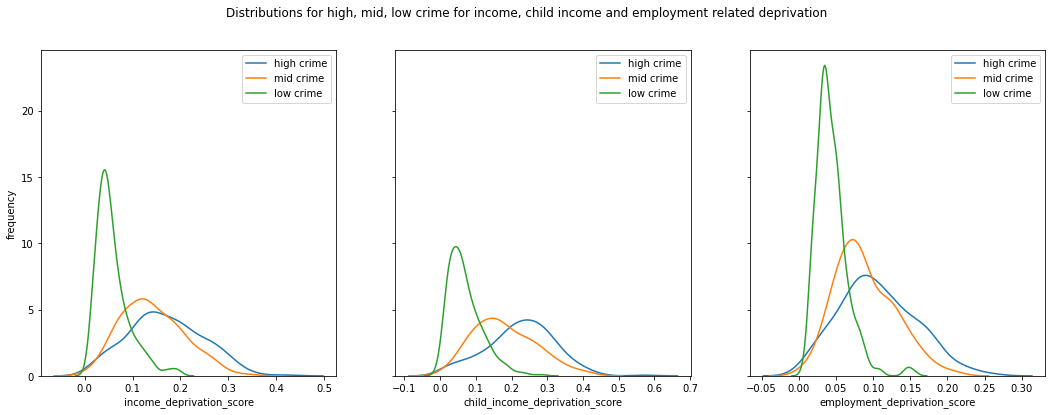

In [35]:
cohort_size = 250
all_cohorts_250 = display_cohort(violence_deprivation, 'crime_per_1000', cohort_size)

### cohort size = 500


Top 500 proportion = 26.87%, middle 500 proportion = 7.23%, bottom 500 proportion = 2.10% 

cohort shape
(1500, 15)


<Figure size 360x360 with 0 Axes>

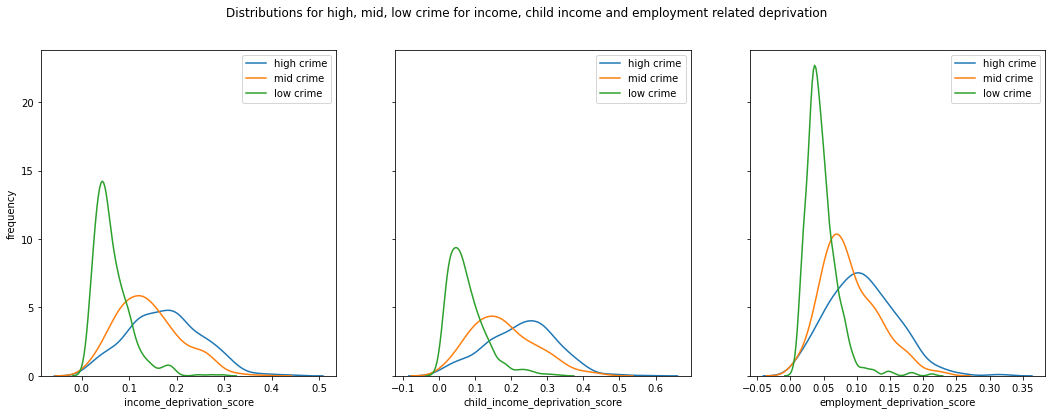

In [36]:
cohort_size = 500
all_cohorts_500 = display_cohort(violence_deprivation, 'crime_per_1000', cohort_size)

### cohort size = 1000


Top 1000 proportion = 42.05%, middle 1000 proportion = 13.19%, bottom 1000 proportion = 5.85% 

cohort shape
(3000, 15)


<Figure size 360x360 with 0 Axes>

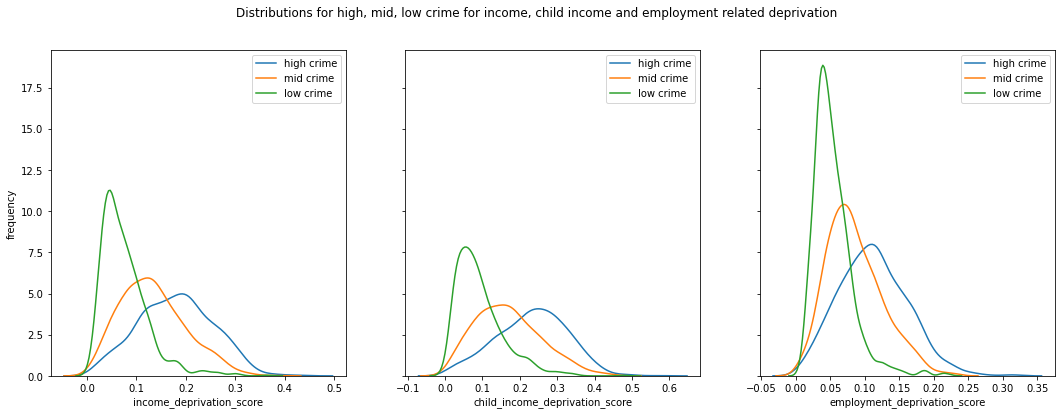

In [37]:
cohort_size = 1000
all_cohorts_1000 = display_cohort(violence_deprivation, 'crime_per_1000', cohort_size)

### Cohen's D
Now calculate and report Cohen's D:
- For each cohort size: all_cohorts_250, all_cohorts_500 
- (we then retrospectively added all_cohorts_1000)
- Between high and mid, high and low, mid and low

When assessing effect size, we use the following convention:

- Small Effect Size: d=0.20
- Medium Effect Size: d=0.50
- Large Effect Size: d=0.80

We will also use 2 standard deviations for confidence interval, meaning we have a 95% confidence that the Cohen's D will fall between its upper and lower interval values

In [38]:
# create our dataframe to store results
cohens_d_results = pd.DataFrame(columns=['description',
                                         'effect_size',
                                         'cohens_lower',
                                         'cohens_upper']) 

# all_cohorts_250
num_stds = 2
sample_size = 250

all_cohorts = all_cohorts_250
all_cohorts_high = all_cohorts[all_cohorts.crime_cohort == 'high']
all_cohorts_mid = all_cohorts[all_cohorts.crime_cohort == 'mid']
all_cohorts_low = all_cohorts[all_cohorts.crime_cohort == 'low']

cohens_d_results = cohens_d_results.append(cohens_d(all_cohorts_high.income_deprivation_score,
                                              all_cohorts_mid.income_deprivation_score, num_stds, 
                                              'income(250): high vs mid', sample_size), ignore_index=True)
cohens_d_results = cohens_d_results.append(cohens_d(all_cohorts_high.income_deprivation_score,
                                              all_cohorts_low.income_deprivation_score, num_stds, 
                                              'income(250): high vs low', sample_size), ignore_index=True)
cohens_d_results = cohens_d_results.append(cohens_d(all_cohorts_mid.income_deprivation_score,
                                              all_cohorts_low.income_deprivation_score, num_stds, 
                                              'income(250): mid vs low', sample_size), ignore_index=True)
cohens_d_results = cohens_d_results.append(cohens_d(all_cohorts_high.child_income_deprivation_score,
                                              all_cohorts_mid.child_income_deprivation_score, num_stds, 
                                              'child income(250): high vs mid', sample_size), ignore_index=True)
cohens_d_results = cohens_d_results.append(cohens_d(all_cohorts_high.child_income_deprivation_score,
                                              all_cohorts_low.child_income_deprivation_score, num_stds, 
                                              'child income(250): high vs low', sample_size), ignore_index=True)
cohens_d_results = cohens_d_results.append(cohens_d(all_cohorts_mid.child_income_deprivation_score,
                                              all_cohorts_low.child_income_deprivation_score, num_stds, 
                                              'child income(250): mid vs low', sample_size), ignore_index=True)
cohens_d_results = cohens_d_results.append(cohens_d(all_cohorts_high.employment_deprivation_score,
                                              all_cohorts_mid.employment_deprivation_score, num_stds, 
                                              'employment(250): high vs mid', sample_size), ignore_index=True)
cohens_d_results = cohens_d_results.append(cohens_d(all_cohorts_high.employment_deprivation_score,
                                              all_cohorts_low.employment_deprivation_score, num_stds, 
                                              'employment(250): high vs low', sample_size), ignore_index=True)
cohens_d_results = cohens_d_results.append(cohens_d(all_cohorts_mid.employment_deprivation_score,
                                              all_cohorts_low.employment_deprivation_score, num_stds, 
                                              'employment(250): mid vs low', sample_size), ignore_index=True)

# all_cohorts_500
num_stds = 2
sample_size = 500

all_cohorts = all_cohorts_500
all_cohorts_high = all_cohorts[all_cohorts.crime_cohort == 'high']
all_cohorts_mid = all_cohorts[all_cohorts.crime_cohort == 'mid']
all_cohorts_low = all_cohorts[all_cohorts.crime_cohort == 'low']

cohens_d_results = cohens_d_results.append(cohens_d(all_cohorts_high.income_deprivation_score,
                                              all_cohorts_mid.income_deprivation_score, num_stds, 
                                              'income(500): high vs mid', sample_size), ignore_index=True)
cohens_d_results = cohens_d_results.append(cohens_d(all_cohorts_high.income_deprivation_score,
                                              all_cohorts_low.income_deprivation_score, num_stds, 
                                              'income(500): high vs low', sample_size), ignore_index=True)
cohens_d_results = cohens_d_results.append(cohens_d(all_cohorts_mid.income_deprivation_score,
                                              all_cohorts_low.income_deprivation_score, num_stds, 
                                              'income(500): mid vs low', sample_size), ignore_index=True)
cohens_d_results = cohens_d_results.append(cohens_d(all_cohorts_high.child_income_deprivation_score,
                                              all_cohorts_mid.child_income_deprivation_score, num_stds, 
                                              'child income(500): high vs mid', sample_size), ignore_index=True)
cohens_d_results = cohens_d_results.append(cohens_d(all_cohorts_high.child_income_deprivation_score,
                                              all_cohorts_low.child_income_deprivation_score, num_stds, 
                                              'child income(500): high vs low', sample_size), ignore_index=True)
cohens_d_results = cohens_d_results.append(cohens_d(all_cohorts_mid.child_income_deprivation_score,
                                              all_cohorts_low.child_income_deprivation_score, num_stds, 
                                              'child income(500): mid vs low', sample_size), ignore_index=True)
cohens_d_results = cohens_d_results.append(cohens_d(all_cohorts_high.employment_deprivation_score,
                                              all_cohorts_mid.employment_deprivation_score, num_stds, 
                                              'employment(500): high vs mid', sample_size), ignore_index=True)
cohens_d_results = cohens_d_results.append(cohens_d(all_cohorts_high.employment_deprivation_score,
                                              all_cohorts_low.employment_deprivation_score, num_stds, 
                                              'employment(500): high vs low', sample_size), ignore_index=True)
cohens_d_results = cohens_d_results.append(cohens_d(all_cohorts_mid.employment_deprivation_score,
                                              all_cohorts_low.employment_deprivation_score, num_stds, 
                                              'employment(500): mid vs low', sample_size), ignore_index=True)

# all_cohorts_1000
num_stds = 2
sample_size = 1000

all_cohorts = all_cohorts_1000
all_cohorts_high = all_cohorts[all_cohorts.crime_cohort == 'high']
all_cohorts_mid = all_cohorts[all_cohorts.crime_cohort == 'mid']
all_cohorts_low = all_cohorts[all_cohorts.crime_cohort == 'low']

cohens_d_results = cohens_d_results.append(cohens_d(all_cohorts_high.income_deprivation_score,
                                              all_cohorts_mid.income_deprivation_score, num_stds, 
                                              'income(1000): high vs mid', sample_size), ignore_index=True)
cohens_d_results = cohens_d_results.append(cohens_d(all_cohorts_high.income_deprivation_score,
                                              all_cohorts_low.income_deprivation_score, num_stds, 
                                              'income(1000): high vs low', sample_size), ignore_index=True)
cohens_d_results = cohens_d_results.append(cohens_d(all_cohorts_mid.income_deprivation_score,
                                              all_cohorts_low.income_deprivation_score, num_stds, 
                                              'income(1000): mid vs low', sample_size), ignore_index=True)
cohens_d_results = cohens_d_results.append(cohens_d(all_cohorts_high.child_income_deprivation_score,
                                              all_cohorts_mid.child_income_deprivation_score, num_stds, 
                                              'child income(1000): high vs mid', sample_size), ignore_index=True)
cohens_d_results = cohens_d_results.append(cohens_d(all_cohorts_high.child_income_deprivation_score,
                                              all_cohorts_low.child_income_deprivation_score, num_stds, 
                                              'child income(1000): high vs low', sample_size), ignore_index=True)
cohens_d_results = cohens_d_results.append(cohens_d(all_cohorts_mid.child_income_deprivation_score,
                                              all_cohorts_low.child_income_deprivation_score, num_stds, 
                                              'child income(1000): mid vs low', sample_size), ignore_index=True)
cohens_d_results = cohens_d_results.append(cohens_d(all_cohorts_high.employment_deprivation_score,
                                              all_cohorts_mid.employment_deprivation_score, num_stds, 
                                              'employment(1000): high vs mid', sample_size), ignore_index=True)
cohens_d_results = cohens_d_results.append(cohens_d(all_cohorts_high.employment_deprivation_score,
                                              all_cohorts_low.employment_deprivation_score, num_stds, 
                                              'employment(1000): high vs low', sample_size), ignore_index=True)
cohens_d_results = cohens_d_results.append(cohens_d(all_cohorts_mid.employment_deprivation_score,
                                              all_cohorts_low.employment_deprivation_score, num_stds, 
                                              'employment(1000): mid vs low', sample_size), ignore_index=True)

In [39]:
cohens_d_tidy = pd.melt(cohens_d_results, id_vars=['description'], 
                        value_vars=['effect_size', 
                                    'cohens_lower',
                                    'cohens_upper'], var_name = 'measure', value_name='value')

In [40]:
measures_ = ["cohens_lower", "cohens_upper", "effect_size"]
measure_colours_ = ["rgb(211,211,211)", "rgb(211,211,211)", "rgb(69,69,69)"]
colours_obj_1 = alt.Color("measure:N", scale=alt.Scale(domain=measures_, range=measure_colours_), legend=None)

alt.Chart(cohens_d_tidy, title='Cohens D: Effect Size and Confidence Intervals').mark_circle(size=100).encode(
    x=alt.X('value:Q', axis=alt.Axis(title='value', ticks=False,values=[0, 0.5, 1.0, 1.5, 2.0, 2.5])),
    y=alt.Y('description:N', axis=alt.Axis(title=None, ticks=False), sort='-x'),
    color=colours_obj_1,
    tooltip=['value']
).configure_axis(
    grid=False,
    domain=False
).configure_view(
    strokeWidth=0).interactive()


alt.Chart(...)

In [41]:
cohens_d_results.sort_values(by='effect_size', ascending=False)

description effect_size cohens_lower cohens_upper
4    child income(250): high vs low      2.0608       1.8395       2.2822
13   child income(500): high vs low      1.9266       1.7736       2.0797
1          income(250): high vs low      1.8290       1.6160       2.0420
10         income(500): high vs low      1.8091       1.6590       1.9593
22  child income(1000): high vs low      1.7313       1.6265       1.8362
19        income(1000): high vs low      1.6650       1.5612       1.7687
2           income(250): mid vs low      1.5879       1.3827       1.7930
7      employment(250): high vs low      1.5777       1.3729       1.7825
5     child income(250): mid vs low      1.5611       1.3568       1.7654
16     employment(500): high vs low      1.5555       1.4111       1.6998
25    employment(1000): high vs low      1.4577       1.3570       1.5583
8       employment(250): mid vs low      1.3840       1.1849       1.5832
11          income(500): mid vs low      1.3776       1.2369       1.5183
14    child income(500): mid vs low      1.3564       1.2161       1.4967
17      employment(500): mid vs low      1.2035       1.0660       1.3410
20         income(1000): mid vs low      1.0049       0.9100       1.0998
23   child income(1000): mid vs low      0.9910       0.8962       1.0858
26     employment(1000): mid vs low      0.9081       0.8142       1.0021
21  child income(1000): high vs mid      0.6953       0.6032       0.7874
18        income(1000): high vs mid      0.6591       0.5673       0.7510
24    employment(1000): high vs mid      0.5942       0.5028       0.6856
12   child income(500): high vs mid      0.5358       0.4070       0.6645
3    child income(250): high vs mid      0.4939       0.3124       0.6755
9          income(500): high vs mid      0.4777       0.3494       0.6059
15     employment(500): high vs mid      0.4259       0.2980       0.5539
0          income(250): high vs mid      0.3826       0.2021       0.5631
6      employment(250): high vs mid      0.3701       0.1897       0.5505

## Conclusions
We calculated a confidence interval based on 2 standard deviations and so we have a 95% confidence that the effect size falls between the upper and lower cohens D limits.

What these results tell us is that there is a large effect size between mean levels of deprivation in areas with high crime and those with low serious violent crime and there is a medium effect size between areas with high and mid level serious violent crimes

## Things still to do on inferential statistics
1. properly explain the results - I think the most interesting is difference between high and mid and it seems cohort size = 500 gives us best cohens D both in terms of effect size plus also lower bound for confidence interval. So the places that have high crime have higher levels of income, child income and employment deprivation and this is a medium effect size even if we look at the lower bound, in which we have a 95% confidence level (2 standard deviations)
    - I want a line in the plot above showing the range between low and high cohend - I'd also like the text before and after the values (add a string column that I can display to the right of the linked line - have "effect size = x, lower/upper bounds = y, z"
    - we need to look at the specific outliers within the low crime areas, because it will be interesting to see what they are - this was another reason we have more confidence when comparing cohen's D for high to mid because those distributions have far fewer outliers and also they closer to normally distributed, which is necessary to be able to rely on Cohen's D, because it is based on means and standard deviations
    - we probably should have a geospatial plot showing us different slices of high, mid, low
    
2. Definitely need to cycle around again and do the following at borough level - knife crime data, exclusions, children in care, police numbers, police clean up rates and also add in child, income and employment deprivation aggregated to borough level
    - explain we know that crime is more local, but we are just investigating because it's only level for which we have data
    - also explain that we would like to have seen police numbers and clean up rates change over time
3. Maybe, if I have time, look into how child, income, employment deprivation has changed between 2010 and 2019 and see whether there is a correlation between areas with biggest increase and the levels of crime.


## Prepare data for next stage - random forest classifier
Create a dataset comprising, for all LSOAs, socioeconomic characteristics (features) and the rate of serious violent crime per 1000 inhabitants

In [25]:
violence_features_master = pd.merge(crimes_subset_new, london_features, left_on='lsoa_code', 
                            right_on='lsoa_code', how = 'inner')

violence_features_master.rename(columns = {'lsoa_name_x':'lsoa_name'}, inplace = True)
violence_features_master.drop('lsoa_name_y', axis=1, inplace=True)

print(violence_features_master.shape)
violence_features_master.head()

(4823, 34)


lsoa_code               borough  ldn_datastore_total  police_total  \
0  E01000006  Barking and Dagenham                   27          50.0   
1  E01000007  Barking and Dagenham                  130         188.0   
2  E01000008  Barking and Dagenham                   23          89.0   
3  E01000009  Barking and Dagenham                   52         115.0   
4  E01000010  Barking and Dagenham                  211         430.0   

   LSOA Code                  lsoa_name  population  crime_per_1000  \
0  E01000006  Barking and Dagenham 016A        2094       12.893983   
1  E01000007  Barking and Dagenham 015A        2502       51.958433   
2  E01000008  Barking and Dagenham 015B        1597       14.402004   
3  E01000009  Barking and Dagenham 016B        1929       26.956973   
4  E01000010  Barking and Dagenham 015C        3579       58.955015   

   crime_per_1000_proportion   lad_code  ... no_qualifications_pct  \
0                   0.218365  E09000002  ...                 0.182   
1                   0.879936  E09000002  ...                 0.152   
2                   0.243903  E09000002  ...                 0.211   
3                   0.456527  E09000002  ...                 0.186   
4                   0.998426  E09000002  ...                 0.122   

   degree_educated_pct  population_density  median_house_price  \
0                0.329            0.144255            0.034776   
1                0.323            0.093529            0.010444   
2                0.242            0.100393            0.012705   
3                0.350            0.167821            0.012705   
4                0.449            0.111747            0.013775   

   log_rent_social_pct  log_ethnic_other_pct  log_population_density  \
0            -3.411248             -3.528124               -1.936171   
1            -0.898942             -3.905574               -2.369485   
2            -0.406466             -3.371840               -2.298662   
3            -1.584745             -3.588608               -1.784857   
4            -1.343235             -3.408265               -2.191522   

   log_median_house_price  log_ethnic_black_pct  log_ethnic_asian_pct  
0               -3.358826             -2.263997             -0.682052  
1               -4.561768             -1.274199             -1.135220  
2               -4.365794             -0.989502             -1.487060  
3               -4.365794             -2.051083             -0.560744  
4               -4.284878             -1.588531             -0.857324  

[5 rows x 34 columns]

In [26]:
violence_features_master.to_csv('./DataSources/Income and Deprivation/violence_features_master.csv', index=False)